In [1]:
import torch
from torch import Tensor
from torch.optim import Optimizer

from typing import List, Tuple

In [113]:
def lion_(
    weight: Tensor,
    gradient: Tensor,
    momentum: float,
    lr: float,
    betas: Tuple[float, float],
    wd: float,
  ):
  """From https://arxiv.org/abs/2302.06675"""
  beta1, beta2 = betas

  with torch.no_grad():
    # lion update
    update = momentum.mul(beta1).add(gradient, alpha=1. - beta1).sign_()
    weight.mul_(1. - wd * lr).sub_(update, alpha=lr)
    # momentum update
    momentum.mul_(beta2).add_(gradient, alpha=1. - beta2)

class Lion(Optimizer):
  def __init__(self, params, lr=3e-4, betas=(0.95, 0.98), wd=0.01):
    defaults = dict(
        lr=lr,
        betas=betas,
        wd=wd,
    )
    super().__init__(params, defaults)

    self.state['momentum'] = [
        [torch.zeros_like(param) for param in group['params']]
        for group in self.param_groups
    ]

  def step(self, closure=None):
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()
    
    for i, group in enumerate(self.param_groups):
      for j, param in enumerate(group['params']):
        if param.grad is None:
          pass
        lion_(param, param.grad, self.state['momentum'][i][j],
              group['lr'], group['betas'], group['wd'])

    return loss


In [57]:
# Test Lion.
from torchvision import datasets
import torchvision.transforms as T

train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=T.Compose([
        T.ToTensor(),
    ]),
    target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float, device="mps").scatter_(0, torch.tensor(y).to("mps"), value=1))
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor(),
    target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float, device="mps").scatter_(0, torch.tensor(y).to("mps"), value=1))
)

In [40]:
import torch.utils.data

train_dataloader = torch.utils.data.DataLoader(train, batch_size=100)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=100)
label_names = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

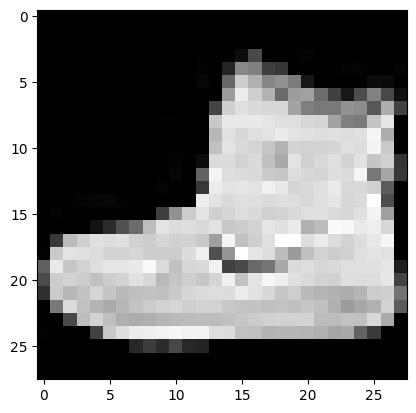

In [43]:
import matplotlib.pyplot as plt
x, y = next(iter(train_dataloader))
plt.imshow(x.view(100, 28, 28)[0], cmap="gray")

In [9]:
import torch.nn as nn
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [114]:
model = FashionCNN().to("mps")

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = Lion(model.parameters(), lr=1e-4)
#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [64]:
next(iter(train_dataloader))[0].shape

torch.Size([100, 1, 28, 28])

In [67]:
from torch.utils.tensorboard import SummaryWriter
import torchvision

writer = SummaryWriter()
images, labels = next(iter(train_dataloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(model, images.to("mps"))

# TODO: there should be a separate val and test dataloader
dataloaders = {
    'train': train_dataloader,
    'val': test_dataloader,
}

for epoch in range(20):
    accuracy = []
    losses = []
    for mode in ['train', 'val']:
        if mode == 'train':
            model.train()
        else:
            model.eval()
        for inputs, labels in dataloaders[mode]:
            inputs, labels = inputs.to("mps"), labels.to("mps")
            outputs = model(inputs)
            loss = error(outputs, labels)
            if mode == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _, preds = torch.max(outputs, 1)
            _, labels = torch.max(labels, 1)
            accuracy.append(torch.sum(preds == labels).item() / len(labels))
            losses.append(loss.item())
        writer.add_scalar(f'loss/{mode}', sum(losses) / len(losses), epoch)
        writer.add_scalar(f'accuracy/{mode}', sum(accuracy) / len(accuracy), epoch)
        

/opt/homebrew/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [68]:
writer.flush()

In [115]:
from torch.autograd import Variable
device = "mps"
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if count % 5 == 0:
            total = 0
            correct = 0
        
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                labels_ = torch.max(labels, 1)[1].to(device)
                correct += (predictions == labels_).sum()
            
                total += len(labels_)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 5, Loss: 1.7653815746307373, Accuracy: 56.83000183105469%
Iteration: 10, Loss: 1.225943922996521, Accuracy: 64.51000213623047%
Iteration: 15, Loss: 0.9552193880081177, Accuracy: 70.6300048828125%
Iteration: 20, Loss: 0.6816796660423279, Accuracy: 73.11000061035156%
Iteration: 25, Loss: 0.705669105052948, Accuracy: 74.55000305175781%
Iteration: 30, Loss: 0.7660759687423706, Accuracy: 73.81000518798828%
Iteration: 35, Loss: 0.50471431016922, Accuracy: 75.93000030517578%
Iteration: 40, Loss: 0.7346146702766418, Accuracy: 77.26000213623047%
Iteration: 45, Loss: 0.4974069893360138, Accuracy: 78.1500015258789%
Iteration: 50, Loss: 0.4821363091468811, Accuracy: 78.2800064086914%
Iteration: 55, Loss: 0.6899384260177612, Accuracy: 77.61000061035156%
Iteration: 60, Loss: 0.5303571224212646, Accuracy: 79.62000274658203%
Iteration: 65, Loss: 0.6787558794021606, Accuracy: 79.75%
Iteration: 70, Loss: 0.4894670844078064, Accuracy: 80.87000274658203%
Iteration: 75, Loss: 0.48478230834007263

KeyboardInterrupt: 